In [129]:
import collections
import math
import os

import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
import scipy.signal
import PIL.Image

from ntsc import *

%matplotlib inline

In [130]:
class Signal:
    def __init__(self, input_filename):
        with np.load("./tv-signal.npz") as f:
            self.sample_rate = f["sample_rate"]
            self._signal = f["signal"]
        
    def __iter__(self):
        return iter(self._generate())
    
    def _generate(self):
        # Each block is ~100µs of samples
        block_ptr = 0
        block_len = int(math.ceil(100 * self.sample_rate))
        while block_ptr < self._signal.shape[0]:
            yield self._signal[block_ptr:block_ptr+block_len, ...]
            block_ptr += block_len
            
            
def noise_blocks(blocks, noise_level):
    for b in blocks:
        yield b + np.random.normal(size=b.shape, scale=noise_level)
            
            
def blocks_filtered_by(blocks, filter_, *, sample_rate):
    buffer_size = int(math.ceil(100 * sample_rate)) # ~ 100µs
    prior_block = np.zeros((buffer_size, ))
    for block in blocks:
        # Prepend prior block to avoid discontinuities around blocks
        filtered_signal = filter_(np.concatenate((prior_block, block)))
        yield filtered_signal[prior_block.shape[0]:]
        prior_block = filtered_signal[-buffer_size:]

def channel_filter(blocks, sample_rate, *, bandwidth=6, noise=0):
    # Simulate a bandwidth limit with a Butterworth low-pass filter.
    sos = scipy.signal.butter(5, bandwidth, analog=False, btype="low", fs=sample_rate, output="sos")
    for b in blocks_filtered_by(noise_blocks(blocks, noise), lambda s: scipy.signal.sosfilt(sos, s), sample_rate=sample_rate):
        yield b

In [131]:
def composite_sync(block):
    "Recover a composite sync signal for a block by thresholding"
    # Implement sync separator from https://www.ntsc-tv.com/images/tv/sync-sp.gif
    clip_level = -25
    return np.where(block >= clip_level, 1.0, 0.0)


def recover_vsync(cs, sample_rate):
    # We restore the vertical sync by low-pass filtering the composite sync.
    # We need a -3dB frequency which is above the line frequency (so we
    # retrive the vsync pulse) but which is well below the frequency implied by
    # the hsync pulse length.

    # The frequency implied by the h-sync pulse. (I.e. a period of two
    # times the pulse width.)
    h_sync_implied_frequency = 1 / (2 * H_SYNC_DURATION)

    # Choose a cutoff frequency well below the implied pulse frequence.
    cutoff_frequency = 0.1 * h_sync_implied_frequency

    # A simple first order Butterworth filter. Some TVs just use an passive RC filter for this
    # and so we don't need to be too clever.
    sos = scipy.signal.butter(1, cutoff_frequency, analog=False, btype="low", fs=sample_rate, output="sos")
    lowpass_signal = scipy.signal.sosfilt(sos, cs)
    return lowpass_signal

    # Compute VSync via comparator.
    return np.where(lowpass_signal < 0.66, 0, 1)


def fields(blocks, *, sample_rate):
    "Yield pairs giving snipped region from vsync to vsync and the recovered hsync for the region."
    # Build up a buffer of blocks. When we find a start end end vsync pulse in the
    # buffer we yield a section of the buffer as a field between the pulses.
    block_buffer = collections.deque()
    block_buffer_len = 0
    
    # Minimum number of samples in the buffer to attempt field detection. A full
    # frame should contain two vsync pulses and so we buffer just over one frame.
    min_buffer_len = int(math.ceil(FRAME_TOTAL_LINES * LINE_DURATION * sample_rate * 1.2))
    
    for block in blocks:
        block_buffer.append(block)
        block_buffer_len += block.shape[0]
        if block_buffer_len < min_buffer_len:
            continue
            
        # We have a buffer we expect to contain at least two vsyncs. Snip it out
        buffer_samples = np.concatenate(block_buffer)
        
        # Get composite sync
        cs = composite_sync(buffer_samples)
        
        # Low-pass filter and threshold to recover vsync
        vs = recover_vsync(cs, sample_rate)
        
        # Find vsync -ve going edges in the buffer.
        vsync_edges = (np.logical_and(vs[:-1] > 0.5, vs[1:] < 0.5)).nonzero()[0]
        
        # Ignore edges within 1 line delay to account for lag in lowpass filter.
        vsync_edges = vsync_edges[vsync_edges > LINE_DURATION * sample_rate]
        
        # There must be at least one edge
        if vsync_edges.shape[0] < 1:
            continue
            
        # Now find the next edge which should be at least one half field in the future
        vsync_start = vsync_edges[0]
        vsync_edges = vsync_edges[vsync_edges > vsync_start + 0.25 * FRAME_TOTAL_LINES * LINE_DURATION * sample_rate]
                                  
        # We expect at least one other edge. Otherwise, snip at the one we have and continue
        if vsync_edges.shape[0] < 1:
            block_buffer = [buffer_samples[vsync_start:]]
            block_buffer_len = block_buffer[0].shape[0]
            continue
            
        vsync_end = vsync_edges[0]
            
        # Put region of buffer around a line and a half before second edge back
        # in block buffer
        block_buffer = [
            buffer_samples[max(0, vsync_end - int(math.ceil(LINE_DURATION * 1.5 * sample_rate))):]
        ]
        block_buffer_len = block_buffer[0].shape[0]
        
        # Yield snipped region
        yield buffer_samples[vsync_start:vsync_end]

In [132]:
def decode_field(field_time, field, sample_rate):  
    # The horizontal sync is recovered by triggering on low-going pulses from the
    # composite sync but not re-triggering for some hold time. (In the sync separator
    # circuit this is done by having the reset line for the one-shot trigger driven
    # by an RC-filter.) Implementing this efficiently in numpy is a little tricky.

    # Compute indices of low-going edges from composite sync.
    cs = composite_sync(field)
    cs_low_going_edge_indices = np.logical_and(cs[:-1] > 0.5, cs[1:] <= 0.5).nonzero()[0]

    # Now many samples in the future must the next low-going edge be? We make this
    # most of a line.
    min_sample_separation = 0.8 * LINE_DURATION * sample_rate

    # Recovered hsync edges
    h_sync_edges = []

    # Walk edges adding in sync pulses.
    for edge_idx in cs_low_going_edge_indices:
        if len(h_sync_edges) == 0 or (edge_idx - h_sync_edges[-1]) >= min_sample_separation:
            h_sync_edges.append(edge_idx)
    
    # Reject first 18 edges to allow hsync to have actually synchronised and stopped
    # being confused by vsync. This should line us up with the start of the active area.
    h_sync_edges = h_sync_edges[18:]
    
    # We must have enough for the actual field
    assert len(h_sync_edges) > FRAME_ACTIVE_LINES >> 1
    
    # What is the fractional difference between hsync and vsync location measured in
    # line delays?
    hv_drift = np.fmod(h_sync_edges[0] / (LINE_DURATION * sample_rate), 1.0)
    
    # Use this to detect even vs odd fields
    is_even = hv_drift > 0.5

    # Expected samples per line
    samples_per_line = int(math.ceil(LINE_DURATION * signal.sample_rate))
    
    # Decode lines
    line_time = field_time
    decoded_lines = np.zeros((FRAME_ACTIVE_LINES>>1, FRAME_H_PIXELS, 3))
    for line_idx, (start_idx, end_idx) in enumerate(zip(h_sync_edges[:FRAME_ACTIVE_LINES>>1], h_sync_edges[1:])):
        line_samples = field[start_idx:end_idx]
        decoded_lines[line_idx, ...] = decode_line(line_idx, field_time + start_idx / sample_rate, line_samples, sample_rate)

    return is_even, decoded_lines

In [133]:
def reconstruct_colourburst_phase(cb_freq, cb_times, cb_samples):
    complex_cb = COLOUR_CARRIER_AMPLITUDE * np.exp(1j * cb_freq * 2 * np.pi * cb_times)
    response = np.sum(cb_samples * complex_cb)
    cb_phase = -np.angle(response)
    return cb_phase

def decode_line(line_idx, line_time, line, sample_rate):
    # Times within line of each sample.
    line_times = line_time + np.arange(line.shape[0]) / sample_rate

    # Prepare buffer for line luma and I/Q components
    line_yiq = np.zeros((line.shape[0], 3))
    
    # Compute chroma bandpass filter based on the nominal colour burst frequency.
    bp_quality = 2
    colourbust_bp_ba = scipy.signal.iirpeak(COLOUR_CARRIER_FREQUENCY, bp_quality, sample_rate)
    
    # Filter line into luma and chroma components
    chroma = scipy.signal.lfilter(*colourbust_bp_ba, x=line)
    line_yiq[..., 0] = (line - chroma - BLACK_LEVEL) / (WHITE_LEVEL - BLACK_LEVEL)

    # Extract colour burst from chroma bandpass filtered signal
    cb_start_sample = int(math.floor(COLOUR_BURST_START_TIME * sample_rate))
    cb_sample_count = int(math.ceil(COLOUR_BURST_START_TIME * sample_rate))
    cb_samples = chroma[cb_start_sample:cb_start_sample+cb_sample_count]
    cb_times = line_times[cb_start_sample:cb_start_sample+cb_sample_count]

    # For the moment we do not attempt to track colourbust frequency.
    cb_phase = reconstruct_colourburst_phase(COLOUR_CARRIER_FREQUENCY, cb_times, cb_samples)

    # Demodulate I and Q components.
    cb_subcarrier = np.exp(1j * (COLOUR_CARRIER_FREQUENCY * 2 * np.pi * line_times + cb_phase))
    line_yiq[..., 1] = np.real(cb_subcarrier) * chroma / COLOUR_CARRIER_AMPLITUDE
    line_yiq[..., 2] = np.imag(cb_subcarrier) * chroma / COLOUR_CARRIER_AMPLITUDE

    # Pass demodulation through lowpass filter using nominal chroma burst frequency.
    colourburst_low_sos = scipy.signal.butter(
        1, 0.2 * COLOUR_CARRIER_FREQUENCY,
        analog=False, btype="lowpass", fs=sample_rate, output="sos"
    )
    line_yiq[..., 1:] = scipy.signal.sosfilt(colourburst_low_sos, line_yiq[..., 1:], axis=0)
    
    # Convert YIQ to RGB
    line_rgb = np.zeros_like(line_yiq)
    line_rgb[..., 0] = line_yiq[..., 1] + line_yiq[..., 0]
    line_rgb[..., 2] = line_yiq[..., 2] + line_yiq[..., 0]
    line_rgb[..., 1] = (line_yiq[..., 0] - 0.3 * line_rgb[..., 0] - 0.11 * line_rgb[..., 2]) / 0.59

    # Resample line into pixels
    line_interpolator = scipy.interpolate.interp1d(x=line_times, y=line_rgb, axis=0, kind="quadratic")
    pixel_duration = ACTIVE_DURATION / FRAME_H_PIXELS
    pixel_times = line_time + np.arange(FRAME_H_PIXELS) * pixel_duration + H_SYNC_DURATION + BACK_PORCH_DURATION
    return np.clip(line_interpolator(pixel_times), 0, 1)

Input signal sampled at 35.77MHz
Detected field at 0.000ms of duration 16.695ms
Detected field at 16.695ms of duration 16.695ms
Detected field at 33.390ms of duration 16.695ms
Detected field at 50.085ms of duration 16.695ms
Detected field at 66.780ms of duration 16.695ms
Detected field at 83.475ms of duration 16.695ms
Detected field at 100.170ms of duration 16.695ms
Detected field at 116.865ms of duration 16.695ms
Detected field at 133.560ms of duration 16.695ms
Detected field at 150.255ms of duration 16.695ms


(-0.5, 639.5, 479.5, -0.5)

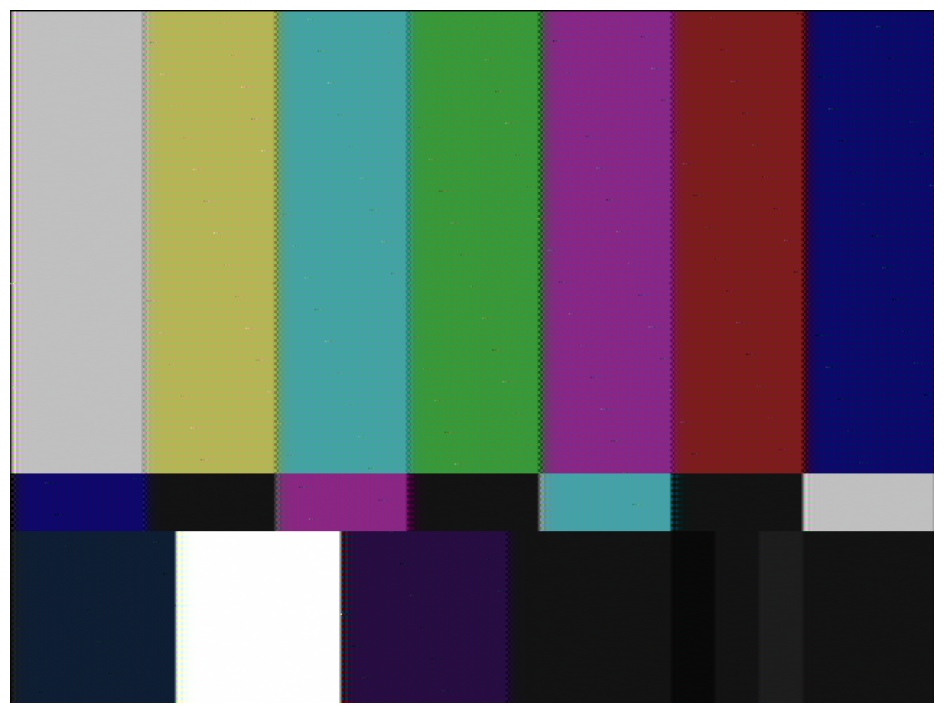

In [134]:
signal = Signal("./tv-signal.npz")
print(f"Input signal sampled at {signal.sample_rate:.2f}MHz")

received_signal_blocks = channel_filter(signal, sample_rate=signal.sample_rate, bandwidth=6, noise=0.1)

# Approximate number of samples per field
expected_field_sample_count = 0.5 * FRAME_TOTAL_LINES * LINE_DURATION * signal.sample_rate

frame_image = 0.5 * np.ones((FRAME_ACTIVE_LINES, FRAME_H_PIXELS, 3))
field_time = 0  # µs
for field_idx, field in enumerate(fields(received_signal_blocks, sample_rate=signal.sample_rate)):
    print(f"Detected field at {field_time*1e-3:.3f}ms of duration {1e-3 * field.shape[0] / signal.sample_rate:.3f}ms")
    
    # Reject field which is too short
    if field.shape[0] < 0.9 * expected_field_sample_count:
        print("Rejecting field which is too short")
        continue
        
    is_even, field_image = decode_field(field_time, field, signal.sample_rate)
    if is_even:
        frame_image[1::2, ...] = field_image
    else:
        frame_image[0::2, ...] = field_image
        
    if field_idx > 1:
        PIL.Image.fromarray((255 * frame_image).astype(np.uint8)).save(
            f"decoded-{field_idx-1:04d}.png"
        )

    field_time += field.shape[0] / signal.sample_rate
    
plt.figure(figsize=(12, 9))
plt.imshow(frame_image)
plt.axis(False)